# Sinkhorn example for 4d gaussians

In [3]:

import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import ot
import ot.plot

In [5]:
import numpy as np

# Set seed
np.random.seed(42)

# Define simple diagonal covariance matrices (no correlation)
mean1 = np.array([0, 0, 0, 0])
cov1 = np.diag([10, 9, 7, 13])

mean2 = np.array([10, -5, 3, 7])
cov2 = np.diag([2, 2, 2, 2])

# Generate samples
n_samples = 1000
X = np.random.multivariate_normal(mean1, cov1, size=n_samples)
Y = np.random.multivariate_normal(mean2, cov2, size=n_samples)

In [6]:
res = ot.solve_sample(X, Y, method='gaussian')

# recover the squared Gaussian
# Bures-Wasserstein distance
BW_dist = res.value
print(BW_dist)

191.37898832858454


In [9]:
# reg term
lambd = 0.7

W = ot.bregman.empirical_sinkhorn2(X, Y, lambd)


In [10]:
print(W.shape)
print(W)

()
193.6551530328423


## Plot as a function of $\lambda$ and $N$

/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 35
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


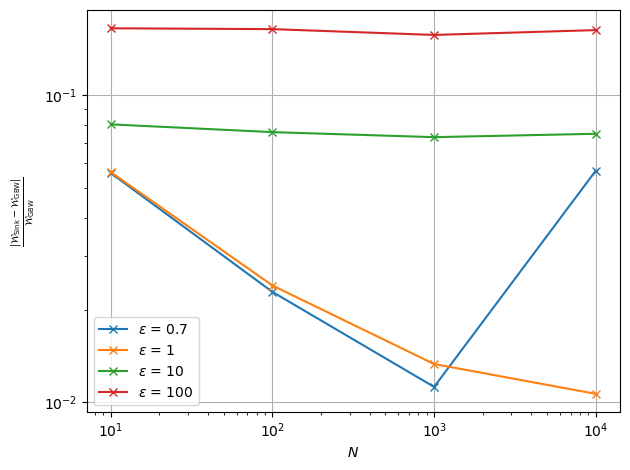

In [12]:
# Define ranges
sample_sizes = [10**i for i in range(1,5)]
epsilons = [0.7, 1, 10, 100]
results = {eps: [] for eps in epsilons}

# Run experiment
for n in sample_sizes:
    X = np.random.multivariate_normal(mean1, cov1, size=n)
    Y = np.random.multivariate_normal(mean2, cov2, size=n)

    # Compute ground truth BW distance
    BW_dist = ot.solve_sample(X, Y, method='gaussian').value

    for eps in epsilons:
        W = ot.bregman.empirical_sinkhorn2(X, Y, reg=eps)
        rel_error = abs(W - BW_dist) / abs(BW_dist)
        results[eps].append(rel_error)

# Plot
for eps in epsilons:
    plt.loglog(sample_sizes, results[eps], marker='x', linestyle='-', label=fr"$\epsilon$ = {eps}")


plt.xlabel(r"$N$")
plt.ylabel(r"$\frac{|\mathcal{W}_{\mathrm{Sink}} - \mathcal{W}_{\mathrm{GBW}}|}{\mathcal{W}_{\mathrm{GBW}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('4d_gaussian_sinkhorn.png', dpi=300, bbox_inches='tight')
plt.show()


# Sinkhorn 1D

In [2]:

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

In [3]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
m1 = 20
s1 = 5
m2 = 60
s2 = 10
a = gauss(n, m1, s1)  # m= mean, s= std
b = gauss(n, m2, s2)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
# M /= M.max()  # normalize
epsilon = 0.01


In [4]:
import sys
import os

# add the parent directory of the current notebook to the import path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# now you can import whatever lives there
from wasserstein_distances import bures_wasserstein_distance_gaussian, entropic_wasserstein_gaussian

from projected_sinkhorn import sinkhorn
# 1) choose regularization ε and build kernel K = exp(–ε M)

eta = 1/epsilon
K = np.exp(-eta * M)

# 2) choose number of Sinkhorn iterations
T = 100

# 3) run Sinkhorn (and track the rounded-coupling costs via compute_otvals)
P, err, otvals = sinkhorn(
    K, a, b, T,
    compute_otvals=True,
    C=M
)

# 4b) cost of the final *rounded* coupling
W_rounded  = otvals[-1]
print(f"Rounded-coupling OT cost     : {W_rounded:.6f}")

Rounded-coupling OT cost     : 1729.592027


In [5]:
dist1 = bures_wasserstein_distance_gaussian(m1, s1, m2, s2)
print(f"1D Bures–Wasserstein distance (squared branch): {dist1:.4f}")

# 1) run Sinkhorn to get the coupling P
P = ot.bregman.sinkhorn_epsilon_scaling(a, b, M, epsilon)
P_k = ot.bregman.sinkhorn_knopp(a, b, M, epsilon)

# 2) compute the regularized transport cost
W_reg = np.sum(P * M)
print(f"Entropic‐regularized OT cost: {W_reg:.5f}")
print(np.sum(P_k * M))

1D Bures–Wasserstein distance (squared branch): 1625.0000
Entropic‐regularized OT cost: 1625.05999
9.593786031661532e-43


/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1331: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 7
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


## Error computation for different variations of Sinkhorn algorithm

In [6]:
import pandas as pd
# Epsilon grid
epsilons = np.linspace(0.001, 16, 75)

# Prepare results container
results = {
    'epsilon': [],
    'W_es': [], 'err_es': [],
    'W_custom': [], 'err_custom': [],
    'W_gh': [], 'err_gh': [],
    'W_sk': [], 'err_sk': []
}

# Sweep over epsilons
for eps in epsilons:
    # 1) POT's epsilon-scaling Sinkhorn
    try:
        P_es = ot.bregman.sinkhorn_epsilon_scaling(a, b, M, eps)
        W_es = np.sum(P_es * M)
    except Exception:
        W_es = np.nan
    err_es = ((W_es - dist1)**2) / (dist1**2) if not np.isnan(W_es) else np.nan

    # 2) Custom Sinkhorn
    K = np.exp(-eps * M)
    try:
        P_c, _, otvals_c = sinkhorn(K, a, b, T, compute_otvals=True, C=M)
        W_c = otvals_c[-1]
    except Exception:
        W_c = np.nan
    err_c = ((W_c - dist1)**2) / (dist1**2) if not np.isnan(W_c) else np.nan

    # 3) POT's Greenkhorn
    try:
        P_gh = ot.bregman.greenkhorn(a, b, M, reg=eps)
        W_gh = np.sum(P_gh * M)
    except Exception:
        W_gh = np.nan
    err_gh = ((W_gh - dist1)**2) / (dist1**2) if not np.isnan(W_gh) else np.nan

    # 4) POT's Sinkhorn-Knopp
    try:
        P_sk = ot.sinkhorn(a, b, M, eps)
        W_sk = np.sum(P_sk * M)
    except Exception:
        W_sk = np.nan
    err_sk = ((W_sk - dist1)**2) / (dist1**2) if not np.isnan(W_sk) else np.nan

    # Append
    results['epsilon'].append(eps)
    results['W_es'].append(W_es)
    results['err_es'].append(err_es)
    results['W_custom'].append(W_c)
    results['err_custom'].append(err_c)
    results['W_gh'].append(W_gh)
    results['err_gh'].append(err_gh)
    results['W_sk'].append(W_sk)
    results['err_sk'].append(err_sk)

# Create DataFrame
df = pd.DataFrame(results)

/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1069: RuntimeWarning: overflow encountered in scalar divide
  new_u = a[i_1] / nx.dot(K[i_1, :], v)
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1070: RuntimeWarning: invalid value encountered in multiply
  G[i_1, :] = new_u * K[i_1, :] * v
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1072: RuntimeWarning: invalid value encountered in multiply
  viol[i_1] = nx.dot(new_u * K[i_1, :], v) - a[i_1]
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1073: RuntimeWarning: invalid value encountered in multiply
  viol_2 += K[i_1, :].T * (new_u - old_u) * v
/home/kleon/anaconda3/envs/stochastic/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:1078: RuntimeWarning: invalid value encountered in multiply
  G[:, i_2] = u * K[:, i_2] * new_v
/home/kleon/anaconda3/envs/stochast

In [8]:
df.head()   # renders the first 5 rows as a nice table
# df.tail()   # same for the last 5 rows

,epsilon,W_es,err_es,W_custom,err_custom,W_gh,err_gh,W_sk,err_sk
0,0.001000,1625.025459,2.454607e-10,1714.870161,0.003059,NaN,NaN,0.000000,1.000000
1,0.217203,1625.062948,1.500560e-09,1688.613038,0.001532,NaN,NaN,0.179234,0.999779
2,0.433405,1625.082300,2.565009e-09,1750.301726,0.005946,NaN,NaN,0.673343,0.999171
3,0.649608,1625.150910,8.624354e-09,1757.346057,0.006633,NaN,NaN,1.265661,0.998443
4,0.865811,1625.247703,2.323561e-08,1754.263252,0.006328,NaN,NaN,2.119661,0.997393


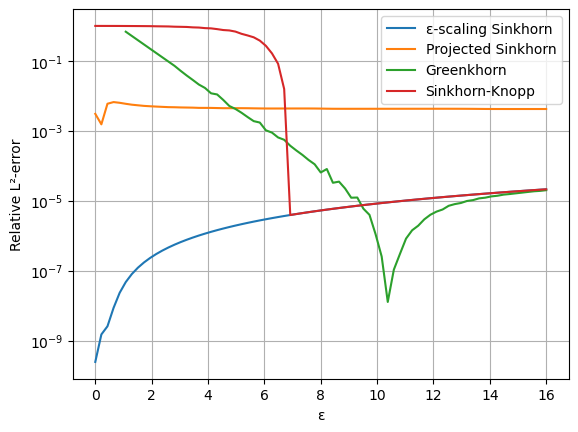

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assume df is already defined in the notebook

# Extract epsilon and error columns
eps = df['epsilon'].values

methods = {
    'ε-scaling Sinkhorn': 'err_es',
    'Projected Sinkhorn': 'err_custom',
    'Greenkhorn': 'err_gh',
    'Sinkhorn-Knopp': 'err_sk'
}

plt.figure()
for label, col in methods.items():
    y = df[col].values
    # Mask out NaN values
    mask = ~np.isnan(y)
    plt.plot(eps[mask], y[mask], label=label)

plt.yscale('log')
plt.xlabel('ε')
plt.ylabel('Relative L²-error')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import pandas as pd
import time
import ot
from scipy.linalg import sqrtm

# ... (re)define your helpers and data setup here:
# entropic_wasserstein_gaussian, sinkhorn, bures_wasserstein_distance_gaussian, etc.

n = 100
x = np.arange(n, dtype=float)
m1, s1 = 20.0, 5.0
m2, s2 = 60.0, 10.0
a = ot.datasets.get_1D_gauss(n, m1, s1)
b = ot.datasets.get_1D_gauss(n, m2, s2)
M = (x.reshape(-1,1) - x.reshape(1,-1))**2
T = 500
dist_ref = (m1 - m2)**2 + (s1 - s2)**2  # W2^2

# precompute the maximum cost
M_max = M.max()

epsilons = np.linspace(0.001, 16, 75)
results = {
    'epsilon': [], 'dyn_range': [],
    'W_ref': [], 'W_analytic': [],
    'W_es': [], 'err_es_ref': [], 'err_es_analytic': [], 'time_es': [],
    'W_custom': [], 'err_c_ref': [], 'err_c_analytic': [], 'time_custom': [],
    'W_gh': [], 'err_gh_ref': [], 'err_gh_analytic': [], 'time_gh': [],
    'W_sk': [], 'err_sk_ref': [], 'err_sk_analytic': [], 'time_sk': []
}

for eps in epsilons:
    # analytic entropic-OT
    W_ae = entropic_wasserstein_gaussian(m1, s1, m2, s2, eps)

    # compute dynamic-range condition number
    #   max(K)=1, min(K)=exp(-M_max/eps)  => dyn_range=1/min(K)=exp(M_max/eps)
    K = np.exp(-M / eps)
    dyn_range = M_max / eps

    # --- ε-scaling Sinkhorn ---
    t0 = time.perf_counter()
    try:
        P_es = ot.bregman.sinkhorn_epsilon_scaling(a, b, M, eps)
        W_es = (P_es * M).sum()
    except:
        W_es = np.nan
    t1 = time.perf_counter()
    err_es_ref = ((W_es - dist_ref)**2)/(dist_ref**2) if not np.isnan(W_es) else np.nan
    err_es_ae  = ((W_es - W_ae)**2)/(W_ae**2)        if not np.isnan(W_es) else np.nan

    # --- Custom Sinkhorn ---
    t2 = time.perf_counter()
    try:
        _, _, otvals_c = sinkhorn(K, a, b, T, True, C=M)
        W_c = otvals_c[-1]
    except:
        W_c = np.nan
    t3 = time.perf_counter()
    err_c_ref = ((W_c - dist_ref)**2)/(dist_ref**2) if not np.isnan(W_c) else np.nan
    err_c_ae  = ((W_c - W_ae)**2)/(W_ae**2)        if not np.isnan(W_c) else np.nan

    # --- Greenkhorn ---
    t4 = time.perf_counter()
    try:
        P_gh = ot.bregman.greenkhorn(a, b, M, reg=eps)
        W_gh = (P_gh * M).sum()
    except:
        W_gh = np.nan
    t5 = time.perf_counter()
    err_gh_ref = ((W_gh - dist_ref)**2)/(dist_ref**2) if not np.isnan(W_gh) else np.nan
    err_gh_ae  = ((W_gh - W_ae)**2)/(W_ae**2)        if not np.isnan(W_gh) else np.nan

    # --- Classical Sinkhorn-Knopp ---
    t6 = time.perf_counter()
    try:
        P_sk = ot.sinkhorn(a, b, M, eps)
        W_sk = (P_sk * M).sum()
    except:
        W_sk = np.nan
    t7 = time.perf_counter()
    err_sk_ref = ((W_sk - dist_ref)**2)/(dist_ref**2) if not np.isnan(W_sk) else np.nan
    err_sk_ae  = ((W_sk - W_ae)**2)/(W_ae**2)        if not np.isnan(W_sk) else np.nan

    # --- Append results ---
    results['epsilon'].append(eps)
    results['dyn_range'].append(dyn_range)
    results['W_ref'].append(dist_ref)
    results['W_analytic'].append(W_ae)

    results['W_es'].append(W_es)
    results['err_es_ref'].append(err_es_ref)
    results['err_es_analytic'].append(err_es_ae)
    results['time_es'].append(t1 - t0)

    results['W_custom'].append(W_c)
    results['err_c_ref'].append(err_c_ref)
    results['err_c_analytic'].append(err_c_ae)
    results['time_custom'].append(t3 - t2)

    results['W_gh'].append(W_gh)
    results['err_gh_ref'].append(err_gh_ref)
    results['err_gh_analytic'].append(err_gh_ae)
    results['time_gh'].append(t5 - t4)

    results['W_sk'].append(W_sk)
    results['err_sk_ref'].append(err_sk_ref)
    results['err_sk_analytic'].append(err_sk_ae)
    results['time_sk'].append(t7 - t6)

# Build the DataFrame
df = pd.DataFrame(results)


/tmp/ipykernel_9211/261464887.py:68: RuntimeWarning: invalid value encountered in multiply
  W_gh = (P_gh * M).sum()


In [8]:
df.head()  # renders the first 5 rows as a nice table

,epsilon,dyn_range,W_ref,W_analytic,W_es,err_es_ref,err_es_analytic,time_es,W_custom,err_c_ref,err_c_analytic,time_custom,W_gh,err_gh_ref,err_gh_analytic,time_gh,W_sk,err_sk_ref,err_sk_analytic,time_sk
0,0.001000,9.801000e+06,1625.0,1600.863143,1625.025459,2.454607e-10,0.000228,0.088763,1729.592027,0.004143,0.006466,0.161526,NaN,NaN,NaN,0.132886,0.000000,1.000000,1.000000,0.000492
1,0.217203,4.512375e+04,1625.0,1601.420411,1625.062948,1.500560e-09,0.000218,0.075823,1742.937753,0.005267,0.007809,0.160164,NaN,NaN,NaN,0.128303,0.179234,0.999779,0.999776,0.000421
2,0.433405,2.261393e+04,1625.0,1601.831488,1625.082300,2.565009e-09,0.000211,0.066675,1748.429002,0.005769,0.008376,0.159230,NaN,NaN,NaN,0.136586,0.673343,0.999171,0.999159,0.000506
3,0.649608,1.508756e+04,1625.0,1602.186972,1625.150910,8.624354e-09,0.000205,0.056613,1749.042640,0.005827,0.008401,0.160829,NaN,NaN,NaN,0.126451,1.265661,0.998443,0.998421,0.000400
4,0.865811,1.132002e+04,1625.0,1602.506607,1625.247703,2.323561e-08,0.000201,0.054442,1743.286936,0.005299,0.007718,0.162831,NaN,NaN,NaN,0.122762,2.119661,0.997393,0.997356,0.000421


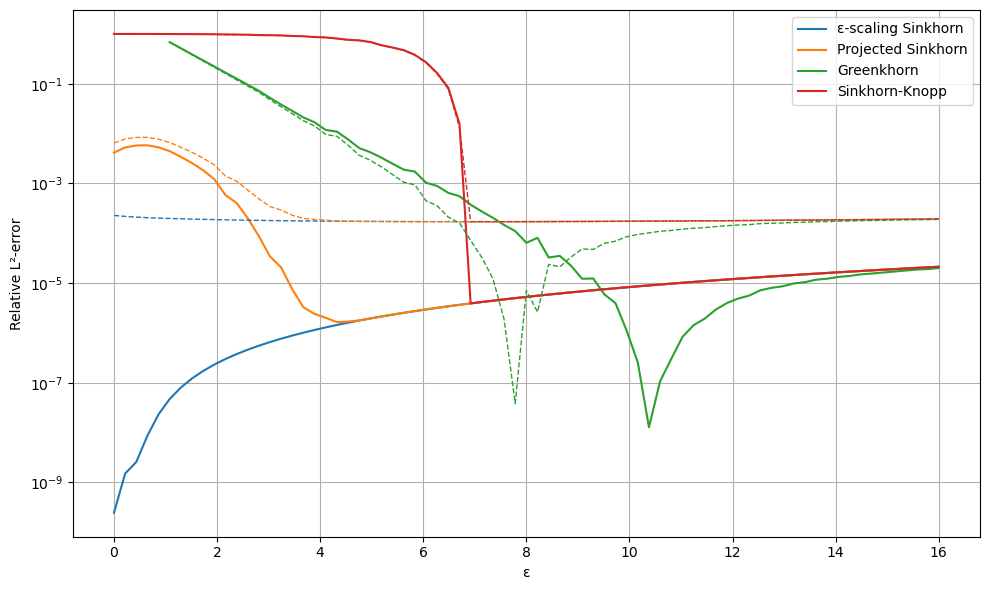

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract epsilon and errors from df
eps = df['epsilon'].values

# Columns for computed vs analytic errors
methods_ref = {
    'ε-scaling Sinkhorn': 'err_es_ref',
    'Projected Sinkhorn': 'err_c_ref',
    'Greenkhorn':         'err_gh_ref',
    'Sinkhorn-Knopp':     'err_sk_ref'
}
methods_analytic = {
    'ε-scaling Sinkhorn': 'err_es_analytic',
    'Projected Sinkhorn': 'err_c_analytic',
    'Greenkhorn':         'err_gh_analytic',
    'Sinkhorn-Knopp':     'err_sk_analytic'
}

plt.figure(figsize=(10,6))

# Plot computed errors (solid)
for label, col in methods_ref.items():
    y = df[col].values
    mask = ~np.isnan(y)
    plt.plot(eps[mask], y[mask], label=label)

# Plot analytic errors (dashed), reusing colors
lines = plt.gca().lines[:len(methods_ref)]
for (label, col), line in zip(methods_analytic.items(), lines):
    y_a = df[col].values
    mask_a = ~np.isnan(y_a)
    plt.plot(
        eps[mask_a], y_a[mask_a],
        linestyle='--',
        color=line.get_color(),
        linewidth=1
    )

plt.yscale('log')
plt.xlabel('ε')
plt.ylabel('Relative L²-error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('1d_gaussian_sinkhorn_errors.png', dpi=300, bbox_inches='tight')
plt.show()


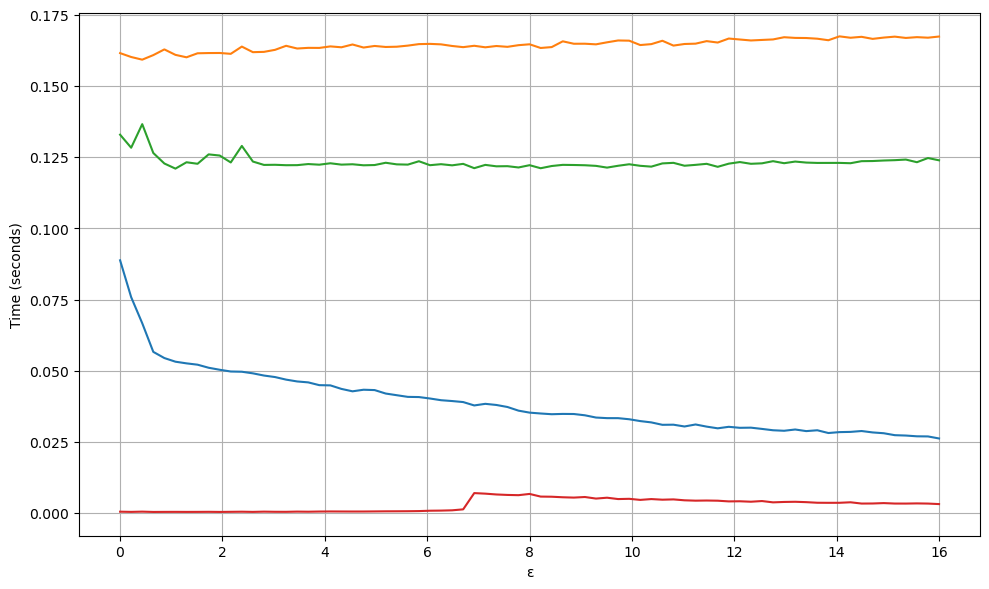

In [15]:
# Extract epsilon and timing columns
eps = df['epsilon'].values

methods_time = {
    'ε-scaling Sinkhorn': 'time_es',
    'Projected Sinkhorn': 'time_custom',
    'Greenkhorn':         'time_gh',
    'Sinkhorn-Knopp':     'time_sk'
}

plt.figure(figsize=(10,6))
for label, col in methods_time.items():
    y = df[col].values
    mask = ~np.isnan(y)
    plt.plot(eps[mask], y[mask], label=label)

plt.xlabel('ε')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('1d_gaussian_sinkhorn_times.png', dpi=300, bbox_inches='tight')
plt.show()

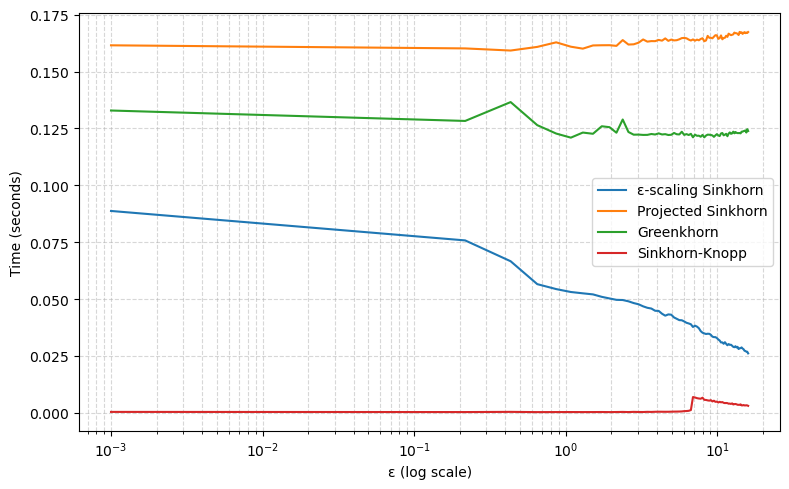

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract epsilon and timing columns
eps = df['epsilon'].values

methods_time = {
    'ε-scaling Sinkhorn': 'time_es',
    'Projected Sinkhorn': 'time_custom',
    'Greenkhorn':         'time_gh',
    'Sinkhorn-Knopp':     'time_sk'
}

plt.figure(figsize=(8,5))
for label, col in methods_time.items():
    y = df[col].values
    mask = ~np.isnan(y)
    plt.plot(eps[mask], y[mask], label=label)

plt.xscale('log')
plt.xlabel('ε (log scale)')
plt.ylabel('Time (seconds)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('1d_gaussian_sinkhorn_times_logx.png', dpi=300, bbox_inches='tight')
plt.show()


## Plot the dynamic range

In [9]:
# If you just want the entire series at once:
print(df['dyn_range'])

# Or, for a more formatted per-ε listing:
for eps, dr in zip(df['epsilon'], df['dyn_range']):
    print(f"ε = {eps:.3f} → dynamic range = {dr}")

0     9.801000e+06
1     4.512375e+04
2     2.261393e+04
3     1.508756e+04
4     1.132002e+04
          ...     
70    6.475638e+02
71    6.384437e+02
72    6.295770e+02
73    6.209532e+02
74    6.125625e+02
Name: dyn_range, Length: 75, dtype: float64
ε = 0.001 → dynamic range = 9801000.0
ε = 0.217 → dynamic range = 45123.747900205315
ε = 0.433 → dynamic range = 22613.93115490147
ε = 0.650 → dynamic range = 15087.557987144017
ε = 0.866 → dynamic range = 11320.024972686124
ε = 1.082 → dynamic range = 9058.112378073913
ε = 1.298 → dynamic range = 7549.589873839364
ε = 1.514 → dynamic range = 6471.789197533619
ε = 1.731 → dynamic range = 5663.282994705855
ε = 1.947 → dynamic range = 5034.352549196544
ε = 2.163 → dynamic range = 4531.150039984007
ε = 2.379 → dynamic range = 4119.400441887279
ε = 2.595 → dynamic range = 3776.2493361518677
ε = 2.812 → dynamic range = 3485.871931789235
ε = 3.028 → dynamic range = 3236.963313398197
ε = 3.244 → dynamic range = 3021.232280397736
ε = 3.460 → dyn

Infinite dynamic range at ε = []


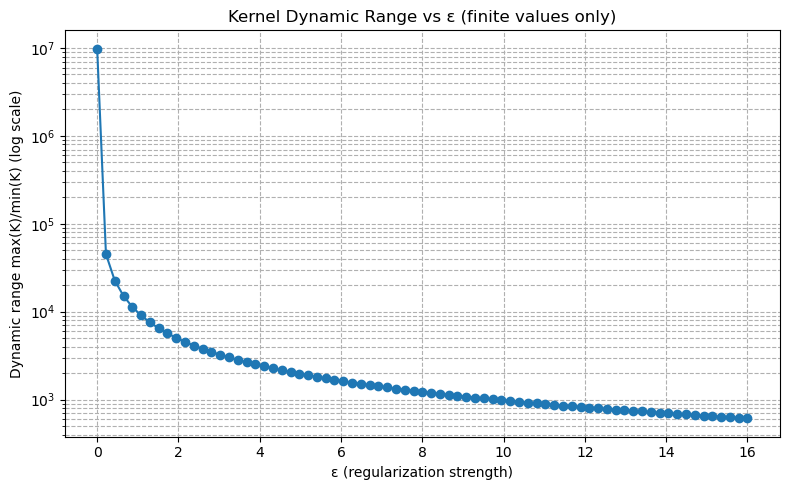

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Identify epsilons where dyn_range is infinite
inf_mask = np.isinf(df['dyn_range'])
eps_inf = df.loc[inf_mask, 'epsilon'].values
print("Infinite dynamic range at ε =", eps_inf)

# 2) Filter to only finite, non-NaN dynamic-range values
finite_mask = df['dyn_range'].notna() & ~inf_mask

# 3) Plot
plt.figure(figsize=(8,5))
plt.plot(df.loc[finite_mask, 'epsilon'],
         df.loc[finite_mask, 'dyn_range'],
         marker='o', linestyle='-')
plt.yscale('log')
plt.xlabel('ε (regularization strength)')
plt.ylabel('Dynamic range max(K)/min(K) (log scale)')
plt.title('Kernel Dynamic Range vs ε (finite values only)')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()
